In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import os
from skimage import io, transform
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import pickle

torch.manual_seed(0)
np.random.seed(0)

In [2]:
import SimPEG.data_misfit as data_misfit

from SimPEG.electromagnetics.static import resistivity as dc

from discretize import TreeMesh, TensorMesh

from SimPEG.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    apparent_resistivity_from_voltage,
    plot_pseudosection,
)

from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)

from SimPEG.utils import sdiag

from SimPEG import SolverLU as Solver

from discretize.utils import mkvc, refine_tree_xyz, active_from_xyz

from SimPEG.utils.io_utils.io_utils_electromagnetics import read_dcip2d_ubc

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
import copy
from time import time

/tmp/ipykernel_614747/649789856.py:1: FutureWarning: Importing `SimPEG` is deprecated. please import from `simpeg`.
  import SimPEG.data_misfit as data_misfit


In [3]:
import matplotlib.colors as colors

In [4]:
class NFTOMO(nn.Module):
    def __init__(self):
         super(NFTOMO, self).__init__()
         self.b1 = nn.Sequential(nn.Linear(2,128), nn.LeakyReLU(inplace = True, negative_slope=0.2))
         self.b2 = nn.Sequential(nn.Linear(128,256), nn.LeakyReLU(inplace = True, negative_slope=0.2))
         self.b3 = nn.Sequential(nn.Linear(256,256), nn.LeakyReLU(inplace = True, negative_slope=0.2))
         self.b4 = nn.Sequential(nn.Linear(256,256), nn.LeakyReLU(inplace = True, negative_slope=0.2))
         self.b5 = nn.Sequential(nn.Linear(256,256), nn.LeakyReLU(inplace = True, negative_slope=0.2))
         self.b6 = nn.Sequential(nn.Linear(256,128), nn.LeakyReLU(inplace = True, negative_slope=0.2))
         self.b7 = nn.Sequential(nn.Linear(128,1), nn.Sigmoid())

    def forward(self, x):
        x1 = self.b1(x)

        x2 = self.b2(x1)

        x3 = self.b3(x2)

        x4 = self.b4(x3)

        x5 = self.b5(x4)

        x6 = self.b6(x5)

        x7 = self.b7(x6)


        return torch.mul(x7,-8)

In [5]:
model = NFTOMO()
directory_name = '../DCR/NF_3_1'
model.load_state_dict(torch.load(directory_name+'/weights.pt'))

<All keys matched successfully>

In [6]:
x1 = np.linspace(-1,1,45)
x2 = np.linspace(-1,1,200)
input_list = []
for i in x1:
  for k in x2:
    input_list.append([i,k])
input_ = torch.tensor(input_list, dtype=torch.float32)

In [7]:
jacob_ = []
input_.requires_grad = False
for param in model.parameters():
    param.requires_grad = True
for i in range(input_.size()[0]):
    in_ = input_[i]*1
    output_ = model(in_)
    der_list = torch.zeros((1))
    for param in model.parameters():
        der_ = torch.autograd.grad(output_[0], param, retain_graph = True)
        der_list = torch.concatenate([der_list,der_[0].flatten()])
    jacob_.append(der_list[1:])

In [8]:
jacob = torch.stack(jacob_)

In [9]:
U, S, V = torch.svd(jacob)

In [10]:
import pickle
f = open('no_encoding_USV_Case_3.pkl', 'wb')
#f = open('no_encoding_USV_DCR.pkl', 'wb')
pickle.dump(U, f)
pickle.dump(S, f)
pickle.dump(V, f)
pickle.dump(jacob, f)
f.close()

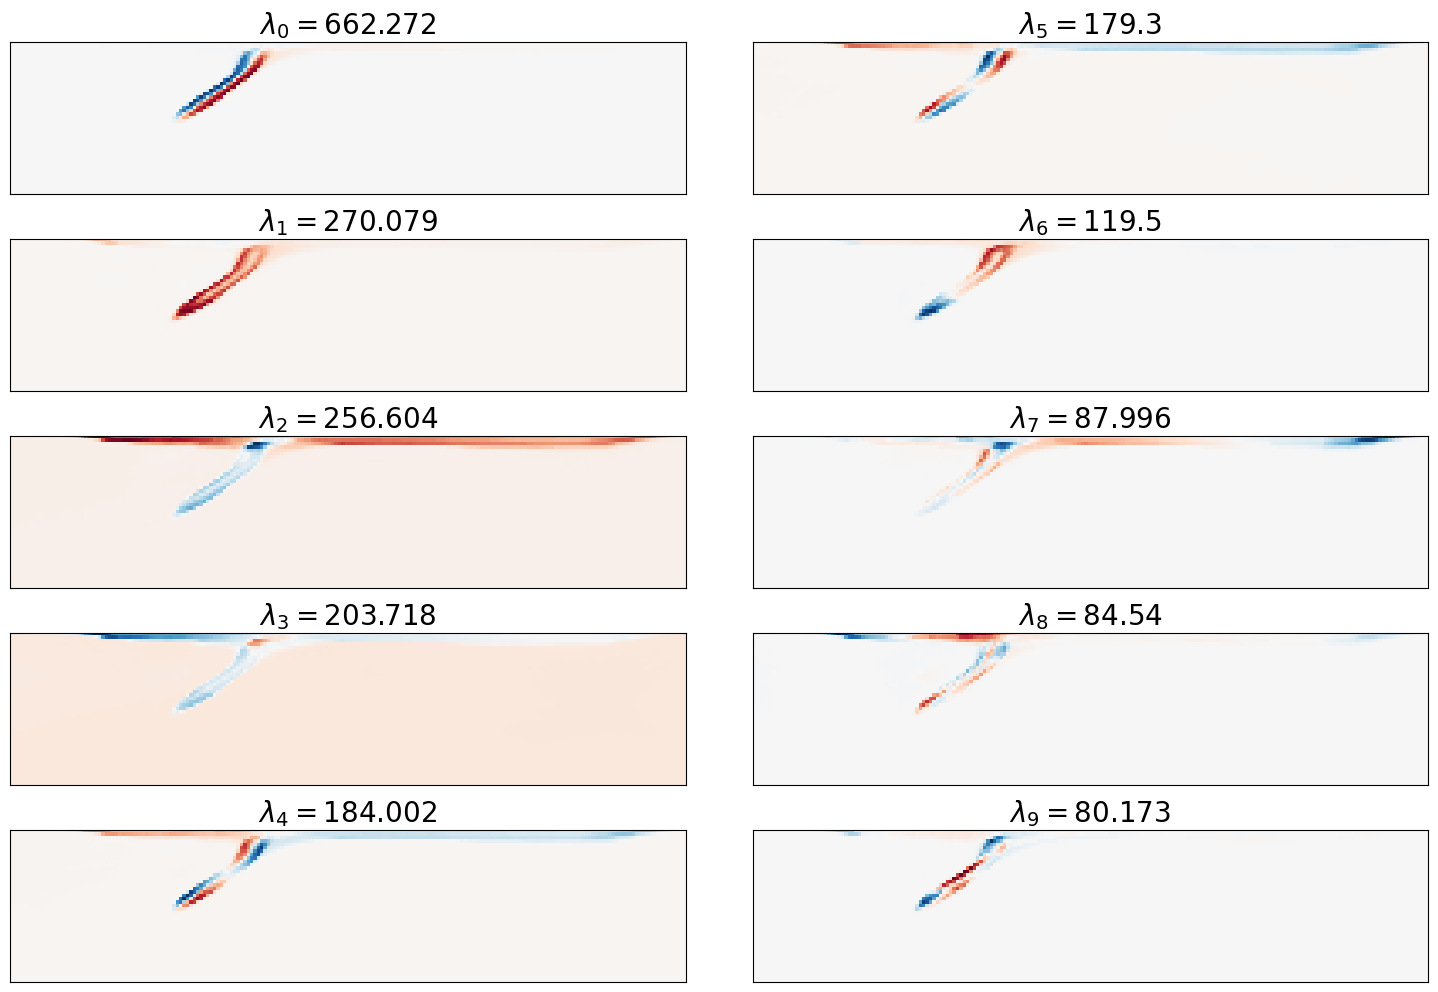

In [32]:
fig, axs = plt.subplots(5,2, figsize=(15,10))
fig.tight_layout()
plt.title('Before training (linear scale)')
for k in range(5):
    axs[k,0].imshow(U[:,k].reshape((45,200)),  'RdBu', origin = 'lower', norm=colors.CenteredNorm())
    axs[k,0].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
    axs[k,0].set_title('$\lambda_{'+str(k)+'}=$' +str(round(S[k].cpu().item() ,3)) , fontsize=20)
for k in range(5):
    axs[k,1].imshow(U[:,k+5].reshape((45,200)),  'RdBu', origin = 'lower', norm=colors.CenteredNorm())
    axs[k,1].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
    axs[k,1].set_title('$\lambda_{'+str(k+5)+'}=$' +str(round(S[k+5].cpu().item() ,3)) , fontsize=20)
    
# plt.savefig('Before_training_(linear_scale).png')